# Predict Bank Customers Churn Probability

In [1]:
%matplotlib inline
import psycopg2
import pickle

from PIL import Image

# data processing
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Supervised Learning
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

# Model Evaluation
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from  scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

# Explainability
import graphviz
import shap

## Utility Functions

In [2]:
def get_data_from_my_postgre_db(password:str, table_name:str)->pd.DataFrame:
    """connects to marketing_analytics db and returns data from table_name as pandas dataframe .
    inputs: database password and table_name"""
    # Connect to the database
    conn = psycopg2.connect(
        database="marketing_analytics", 
        user="postgres", 
        password=password, 
        host="localhost", 
        port="5432")
    # Create a cursor object
    cur = conn.cursor()
    # Execute a SQL query
    #cur.execute("SELECT * FROM bank_customers_churn_dataset")
    cur.execute("SELECT * FROM " + table_name) 
    # Get the column names from the cursor description
    columns = [desc[0] for desc in cur.description]
    # Fetch the results i.e. values
    results = cur.fetchall()
    # Create a dictionary mapping column names to values
    data = [dict(zip(columns, row)) for row in results]
    # Close the connection
    conn.close()
    # turn dictionary into dataframe
    return pd.DataFrame.from_dict(data)

def create_missing_values(df:pd.DataFrame, na_percentage=0.05)->pd.DataFrame:
    """impute missing values in na_percentage of rows in each column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_missing_values = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X.columns:
        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_missing_values)
        for row in random_indices:  
            X.loc[row, col] = np.nan
    return X

def create_outliers(df:pd.DataFrame, numeric_columns:list, na_percentage=0.05)->pd.DataFrame:
    """impute outliers in na_percentage of rows in each numeric column"""
    X = df.copy()
    # Create an array of 5 percent of the number of rows in the dataframe
    num_rows = X.shape[0]
    num_outliers = int(num_rows * na_percentage)

    # Iterate through each row and set the values to np.nan
    for col in X[numeric_columns]:
        # get mean value, standard deviation and minimum
        mean, sd, min = X[col].mean(), X[col].std(), X[col].min()
        # Generate random numbers from normal distribution
        rand_norm = np.random.normal(mean, sd, 1000000)
        # Generate outliers which are at least mean+/-3*std
        if min < 0:
            outliers = np.append(rand_norm[rand_norm < mean-3*sd], rand_norm[rand_norm > mean+3*sd])
        else:
            outliers = rand_norm[rand_norm > mean+3*sd]

        # Get a random sample of rows from 0 to num_rows-1
        random_indices = random.sample(X.index.to_list(), num_outliers)
        for row in random_indices:
            X.loc[row, col] = random.sample(outliers.tolist(), 1)[0]
    return X

def get_class_imbalance_correction_factor(data:pd.DataFrame, target:str):
    """calculate the class imbalance correction factor for the minority class for better fit performance"""
    value_counts = data[target].value_counts() / data.shape[0]
    return value_counts[0] / value_counts[1]

def calculate_churn_rate(data:pd.DataFrame)->float:
    """get the churn rate in percent given data frame with column "churner" labeling whether churned or not"""
    conversion_rate_pct = np.round((data.groupby(by='churner').count().iloc[:,0] / data.shape[0] * 100) [1],2)
    return conversion_rate_pct

def plot_threshold_recall_precision_curves(model, X, y):
    """plot threshold-recall-precision curves given trained model X and y"""
    width=10
    height=np.round(width*.75,0)
    fig, ax = plt.subplots(1, 2, figsize=(width, height))

    y_scores = model.predict_proba(X)[:,1]
    precision, recall, thresholds = precision_recall_curve(y, y_scores)

    ax[0].plot(recall, precision)
    ax[0].set_title("Precision-Recall Curve")
    ax[0].set_xlabel('recall')
    ax[0].set_ylabel('precision')
    ax[0].set_xlim(-0.05, 1.05)
    ax[0].set_ylim(-0.05, 1.05)
    ax[0].grid()

    ax[1].plot(recall, np.insert(thresholds, 0, 0))
    ax[1].set_title("Threshold-Recall Curve")
    ax[1].set_xlabel('recall')
    ax[1].set_ylabel('threshold')
    ax[1].set_xlim(-0.05, 1.05)
    ax[1].set_ylim(-0.05, 1.05)
    ax[1].grid()
    return fig

def plot_confusion_matrix(features:pd.DataFrame, labels:np.array, sklearn_model, threshold=0.5):
    """plot confusion matrix for trained model given labels and one-hotencoded features. Pick a decision threshold for positive class"""
    # make predictions
    preds = sklearn_model.predict_proba(features)[:,1]
    preds = np.where(preds>threshold, 1, 0)
    # calc confusion matrix
    cm = confusion_matrix(labels, preds, labels=sklearn_model.classes_)
    # create matrix display
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,                            
        display_labels=sklearn_model.classes_)
    disp.plot()
    return disp

def plot_cap_lift_curves(model, X, y):
    """plot cummulative gain and lift curves given model, features and target"""
    width=8
    height=np.round(width*.75,0)
    fig, ax = plt.subplots(1, 2, figsize=(width, height))
    ax = ax.flatten()

    plot_cumulative_gain(
        y, 
        model.predict_proba(X),
        title = 'Cumulative Gain Curve',
        ax = ax[0])
    ax[0].set_xlabel('percentage contacted')
    ax[0].set_ylabel('percentage engaged')

    plot_lift_curve(
        y, 
        model.predict_proba(X),
        ax = ax[1])
    ax[1].set_xlabel('percentage contacted')

    return fig

def plot_shap_values(shap_values, topn=5, plot_type='violin'):
    """Violin plot of the shap values"""
    width=16
    height=np.round(width*.75,0)
    shap.summary_plot(
        shap_values = shap_values, 
        features = X,
        sort=True,
        plot_size=(width, height),
        show=False,
        max_display=topn,
        plot_type=plot_type
        )
    ax=plt.gca()
    ax.set_title('Shap Values')
    ax.grid()
    #ax.set_xlim(-.5,.5)
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    return fig

# Import Data

the dataset is available here: https://www.kaggle.com/datasets/mathchi/churn-for-bank-customers

- CustomerId—contains random values and has no effect on customer leaving the bank.
- Surname—the surname of a customer has no impact on their decision to leave the bank.
- CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
- Geography—a customer’s location can affect their decision to leave the bank.
- Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
- Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
- Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
-Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
- NumOfProducts—refers to the number of products that a customer has purchased through the bank.
- HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
- IsActiveMember—active customers are less likely to leave the bank.
- EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.
- Churn—whether or not the customer left the bank.

In [3]:
# load data from local csv 
df = pd.read_csv(
        filepath_or_buffer = '../data/bank_customers_churn_dataset.csv',
        sep=','
)

# set customer id as index
df.set_index('customer_id', inplace=True)

## change churn column type to bool
df['churn'] = df['churn'].astype('int')#.astype('bool')

# change data types to numeric
df['credit_score'] = df['credit_score'].apply(lambda x: int(np.round(x,0)))
df['age'] = df['age'].apply(lambda x: int(np.round(x,0)))
df['tenure'] = df['tenure'].apply(lambda x: int(np.round(x,0)))
df['balance'] = df['balance'].apply(lambda x: int(np.round(x,0)))
df['products_number'] = df['products_number'].apply(lambda x: int(np.round(x,0)))
df['estimated_salary'] = df['estimated_salary'].apply(lambda x: int(np.round(x,0)))

## change type of categorical columns "credit_card" and "active_member"
df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2,0,1,yes,yes,101349,1
15647311,608,Spain,Female,41,1,83808,1,no,yes,112543,0
15619304,502,France,Female,42,8,159661,3,yes,no,113932,1
15701354,699,France,Female,39,1,0,2,no,no,93827,0
15737888,850,Spain,Female,43,2,125511,1,yes,yes,79084,0


In [4]:
#f = open("../private.txt", "r")
#pw = f.read()

In [5]:
## get data from postres db
#table_name = "bank_customers_churn_dataset"
#df = get_data_from_my_postgre_db(pw, table_name)
#
## set customer id as index
#df.set_index('customer_id', inplace=True)
#
## change churn column type to bool
#df['churn'] = df['churn'].astype('int').astype('bool')
#
## change data types to numeric
#df['tenure'] = df['tenure'].apply(lambda x: int(x))
#df['products_number'] = df['products_number'].apply(lambda x: int(x))
#df['credit_card'] = df['credit_card'].apply(lambda x: int(x))
#df['active_member'] = df['active_member'].apply(lambda x: int(x))
#
## change type of categorical columns "credit_card" and "active_member"
#df['credit_card'] = df['credit_card'].apply(lambda x: 'yes' if x == 1 else 'no')
#df['active_member'] = df['active_member'].apply(lambda x: 'yes' if x == 1 else 'no')

In [6]:
df.dtypes

credit_score         int64
country             object
gender              object
age                  int64
tenure               int64
balance              int64
products_number      int64
credit_card         object
active_member       object
estimated_salary     int64
churn                int32
dtype: object

In [7]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,,,,,,,,,,,
15634602,619,France,Female,42,2,0,1,yes,yes,101349,1
15647311,608,Spain,Female,41,1,83808,1,no,yes,112543,0
15619304,502,France,Female,42,8,159661,3,yes,no,113932,1
15701354,699,France,Female,39,1,0,2,no,no,93827,0
15737888,850,Spain,Female,43,2,125511,1,yes,yes,79084,0


## Split Features and Target

In [8]:
# divide features and target
y = df['churn'].values
X = df.drop('churn', axis=1)

## Check Column Types

In [9]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = X.select_dtypes(include=numerics).columns.to_list()
categorical_columns = X.select_dtypes(exclude=numerics).columns.to_list()

print('numeric columns: {}'.format(numeric_columns))
print('categorical columns: {}'.format(categorical_columns))

numeric columns: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical columns: ['country', 'gender', 'credit_card', 'active_member']


In [10]:
# check unique values for categorical values
for col in categorical_columns:
    print('unique values for {}: \n{}'.format(col, df[col].unique()))


unique values for country: 
['France' 'Spain' 'Germany']
unique values for gender: 
['Female' 'Male']
unique values for credit_card: 
['yes' 'no']
unique values for active_member: 
['yes' 'no']


# Train-Test Split the Data

In [11]:
# way too much data for training; let´s split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    stratify=y,
    random_state=123)

In [12]:
X_train.shape

(8000, 10)

In [13]:
X_test.shape

(2000, 10)

In [14]:
X_train.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15759244,687,Germany,Male,44,8,95368,2,yes,yes,1788
15725997,660,France,Female,35,6,100769,1,yes,no,19200
15724296,684,Spain,Male,41,2,119783,2,no,no,120285
15636820,725,Germany,Male,40,8,104150,1,yes,no,62028
15744529,510,France,Male,63,8,0,2,yes,yes,115292


## Simulate Additional Missing Values and Outliers to Ensure the Methods for Recovery Work

In [15]:
# create some more missing data in 5% of all rows to ensure enough missing data to test the missing data imputation methods
X_train = create_missing_values(X_train, na_percentage=0.05)
X_test = create_missing_values(X_test, na_percentage=0.05)

In [16]:
# create additional outliers in 5% of the rows to test out outlier removal method
X_train = create_outliers(X_train, numeric_columns, 0.05)
X_test = create_outliers(X_test, numeric_columns, 0.05)

# Data Analysis Preparation

In [17]:
X_train

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
customer_id,,,,,,,,,,
15759244,687.0,Germany,Male,44.000000,8.0,95368.0,2.0,yes,yes,1788.0
15725997,660.0,NaN,Female,72.011478,NaN,100769.0,1.0,yes,NaN,19200.0
15724296,684.0,NaN,Male,41.000000,2.0,119783.0,2.0,no,no,120285.0
15636820,725.0,Germany,Male,40.000000,8.0,104150.0,1.0,yes,no,62028.0
15744529,510.0,France,Male,63.000000,8.0,NaN,2.0,yes,yes,115292.0
...,...,...,...,...,...,...,...,...,...,...
15628303,738.0,Spain,Male,35.000000,3.0,0.0,1.0,yes,yes,15651.0
15699225,NaN,France,Male,46.000000,0.0,0.0,2.0,yes,no,37460.0
15612525,499.0,France,Female,57.000000,1.0,NaN,1.0,no,no,131372.0


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 15759244 to 15578761
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      7623 non-null   float64
 1   country           7600 non-null   object 
 2   gender            7600 non-null   object 
 3   age               7622 non-null   float64
 4   tenure            7622 non-null   float64
 5   balance           7622 non-null   float64
 6   products_number   7620 non-null   float64
 7   credit_card       7600 non-null   object 
 8   active_member     7600 non-null   object 
 9   estimated_salary  7621 non-null   float64
dtypes: float64(6), object(4)
memory usage: 945.5+ KB


In [19]:
X_train.isna().sum()

credit_score        377
country             400
gender              400
age                 378
tenure              378
balance             378
products_number     380
credit_card         400
active_member       400
estimated_salary    379
dtype: int64

## Impute Missing Values

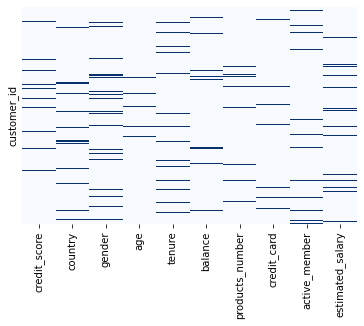

In [20]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [21]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)

## reformat to integer
#X_train_numeric['previous'] = X_train_numeric['previous'].apply(lambda x: np.round(x,0)).astype('int')
#X_train_numeric['campaign'] = X_train_numeric['campaign'].apply(lambda x: np.round(x,0)).astype('int')

X_train_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15759244,687.0,44.000000,8.0,95368.0,2.0,1788.0
15725997,660.0,72.011478,5.0,100769.0,1.0,19200.0
15724296,684.0,41.000000,2.0,119783.0,2.0,120285.0
15636820,725.0,40.000000,8.0,104150.0,1.0,62028.0
15744529,510.0,63.000000,8.0,101215.0,2.0,115292.0


In [22]:
X_train_numeric.dtypes

credit_score        float64
age                 float64
tenure              float64
balance             float64
products_number     float64
estimated_salary    float64
dtype: object

In [23]:
# impute missing numeric values in test dataset
X_test_numeric = numeric_imputer.transform(X_test.select_dtypes(include=numerics))
X_test_numeric = pd.DataFrame(X_test_numeric, columns=numeric_columns, index=X_test.index)

# reformat to integer
X_test_numeric = X_test_numeric.astype('int')

X_test_numeric.head()

,credit_score,age,tenure,balance,products_number,estimated_salary
customer_id,,,,,,
15764618,815,72,6,0,1,85168
15626385,714,33,10,103121,2,49672
15687413,619,38,6,0,2,117616
15759067,537,37,7,158412,4,117691
15614049,664,55,8,0,2,139162


In [24]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15759244,Germany,Male,yes,yes
15725997,France,Female,yes,yes
15724296,France,Male,no,no
15636820,Germany,Male,yes,no
15744529,France,Male,yes,yes


In [25]:
# Impute missing categorical values in test dataset
X_test_categorical = categorical_imputer.transform(X_test.select_dtypes(exclude=numerics))
X_test_categorical = pd.DataFrame(X_test_categorical, columns=categorical_columns, index=X_test.index)
X_test_categorical.head()

,country,gender,credit_card,active_member
customer_id,,,,
15764618,Spain,Female,yes,yes
15626385,Spain,Female,yes,yes
15687413,France,Female,yes,yes
15759067,Germany,Female,yes,yes
15614049,France,Male,yes,yes


In [26]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [27]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15759244,687.0,44.000000,8.0,95368.0,2.0,1788.0,Germany,Male,yes,yes
15725997,660.0,72.011478,5.0,100769.0,1.0,19200.0,France,Female,yes,yes
15724296,684.0,41.000000,2.0,119783.0,2.0,120285.0,France,Male,no,no
15636820,725.0,40.000000,8.0,104150.0,1.0,62028.0,Germany,Male,yes,no
15744529,510.0,63.000000,8.0,101215.0,2.0,115292.0,France,Male,yes,yes


In [28]:
X_test = pd.concat([X_test_numeric, X_test_categorical], axis=1)
X_test.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15764618,815,72,6,0,1,85168,Spain,Female,yes,yes
15626385,714,33,10,103121,2,49672,Spain,Female,yes,yes
15687413,619,38,6,0,2,117616,France,Female,yes,yes
15759067,537,37,7,158412,4,117691,Germany,Female,yes,yes
15614049,664,55,8,0,2,139162,France,Male,yes,yes


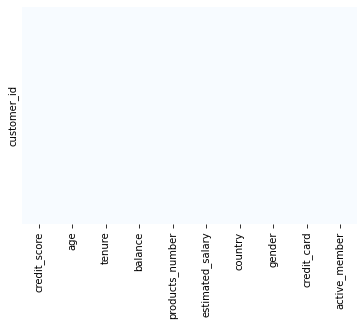

In [29]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_test.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Prepare Categorical Features

In [30]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category country: 
France     4233
Germany    1887
Spain      1880
Name: country, dtype: int64
Value counts in category gender: 
Male      4557
Female    3443
Name: gender, dtype: int64
Value counts in category credit_card: 
yes    5759
no     2241
Name: credit_card, dtype: int64
Value counts in category active_member: 
yes    4316
no     3684
Name: active_member, dtype: int64


## Encode Rare Labels

In [31]:
# encode rare labels in train data
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=5)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable country is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable gender is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable credit_card is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable active_member is less than that indicated in n_categories. Thus, all categories will be considered frequent


,country,gender,credit_card,active_member
customer_id,,,,
15759244,Germany,Male,yes,yes
15725997,France,Female,yes,yes
15724296,France,Male,no,no
15636820,Germany,Male,yes,no
15744529,France,Male,yes,yes


In [32]:
# encode rare labels in test data
X_test[categorical_columns] = rare_encoder.transform(X_test[categorical_columns])
X_test[categorical_columns].head()

,country,gender,credit_card,active_member
customer_id,,,,
15764618,Spain,Female,yes,yes
15626385,Spain,Female,yes,yes
15687413,France,Female,yes,yes
15759067,Germany,Female,yes,yes
15614049,France,Male,yes,yes


In [33]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Prepare Numerical Features

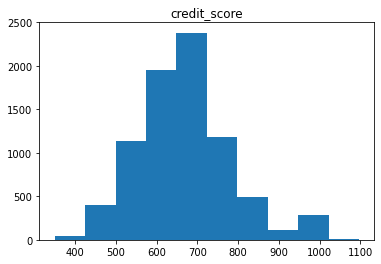

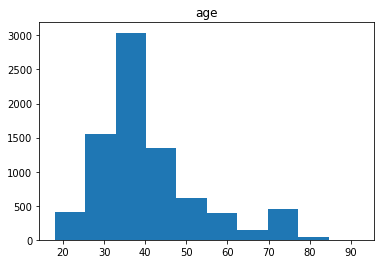

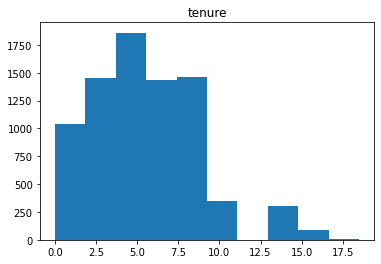

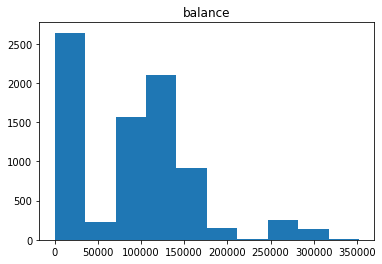

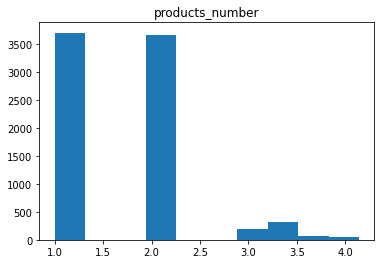

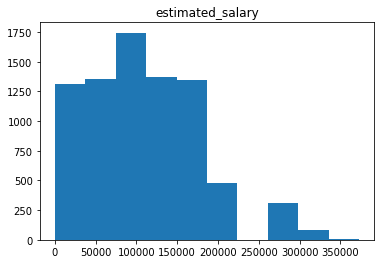

In [34]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [35]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [36]:
# fit the capper on train data
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15759244,687.0,44.000000,8.0,95368.0,2.0,1788.0,Germany,Male,yes,yes
15725997,660.0,72.011478,5.0,100769.0,1.0,19200.0,France,Female,yes,yes
15724296,684.0,41.000000,2.0,119783.0,2.0,120285.0,France,Male,no,no
15636820,725.0,40.000000,8.0,104150.0,1.0,62028.0,Germany,Male,yes,no
15744529,510.0,63.000000,8.0,101215.0,2.0,115292.0,France,Male,yes,yes


In [37]:
# fit the capper on test data
X_test[numeric_columns] = capper.transform(X_test[numeric_columns])
X_test.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
customer_id,,,,,,,,,,
15764618,815.0,72.0,6.0,0.0,1.000000,85168.0,Spain,Female,yes,yes
15626385,714.0,33.0,10.0,103121.0,2.000000,49672.0,Spain,Female,yes,yes
15687413,619.0,38.0,6.0,0.0,2.000000,117616.0,France,Female,yes,yes
15759067,537.0,37.0,7.0,158412.0,3.717905,117691.0,Germany,Female,yes,yes
15614049,664.0,55.0,8.0,0.0,2.000000,139162.0,France,Male,yes,yes


In [38]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

# Data Visualization

### Churn Rate

In [39]:
data = pd.concat([X_train, pd.DataFrame(y_train, columns=['churner'], index=X_train.index)], axis=1)
data.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member,churner
customer_id,,,,,,,,,,,
15759244,687.0,44.000000,8.0,95368.0,2.0,1788.0,Germany,Male,yes,yes,0
15725997,660.0,72.011478,5.0,100769.0,1.0,19200.0,France,Female,yes,yes,0
15724296,684.0,41.000000,2.0,119783.0,2.0,120285.0,France,Male,no,no,0
15636820,725.0,40.000000,8.0,104150.0,1.0,62028.0,Germany,Male,yes,no,0
15744529,510.0,63.000000,8.0,101215.0,2.0,115292.0,France,Male,yes,yes,0


In [40]:
print('Churn rate: {} %'.format(calculate_churn_rate(data))) 

Churn rate: 20.38 %


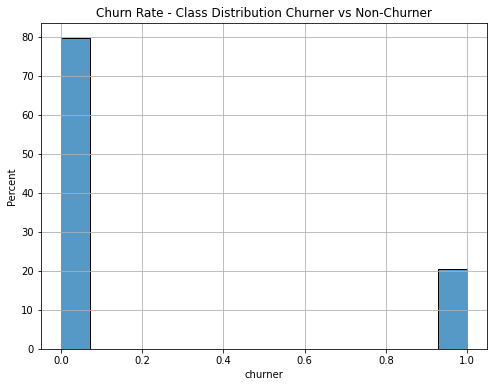

In [41]:
### Visualize Class Distribution

# plot class distribution for converters vs non-converters
fig, ax = plt.subplots(1,1,figsize=(8,6))
sns.histplot(
        data = data,
        x = 'churner',
        stat='percent',
        ax=ax
)
ax.grid()
ax.set_title('Churn Rate - Class Distribution Churner vs Non-Churner')


# save figure
fig.savefig(
        fname='../images/churn_rate.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

#plt.show()

## Visualize Numerical Features

In [42]:
# create numeric data frame
data = pd.concat([X_train[numeric_columns], pd.DataFrame(y_train, index=X_train.index, columns=['churner'])], axis=1)
data.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,churner
customer_id,,,,,,,
15759244,687.0,44.000000,8.0,95368.0,2.0,1788.0,0
15725997,660.0,72.011478,5.0,100769.0,1.0,19200.0,0
15724296,684.0,41.000000,2.0,119783.0,2.0,120285.0,0
15636820,725.0,40.000000,8.0,104150.0,1.0,62028.0,0
15744529,510.0,63.000000,8.0,101215.0,2.0,115292.0,0


In [43]:
data.groupby('churner').agg('median')

,credit_score,age,tenure,balance,products_number,estimated_salary
churner,,,,,,
0,658.0,37.0,5.0,100913.0,2.0,105218.0
1,657.0,45.0,5.0,109483.0,1.0,105218.0


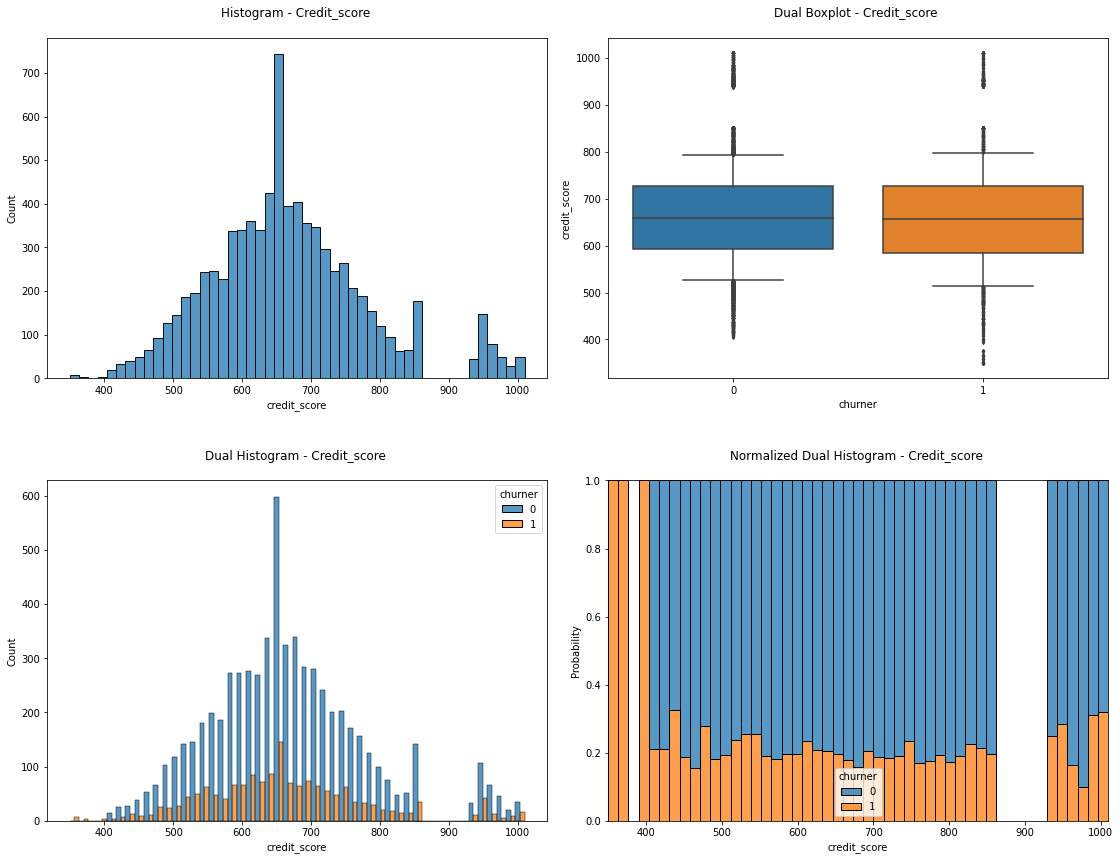

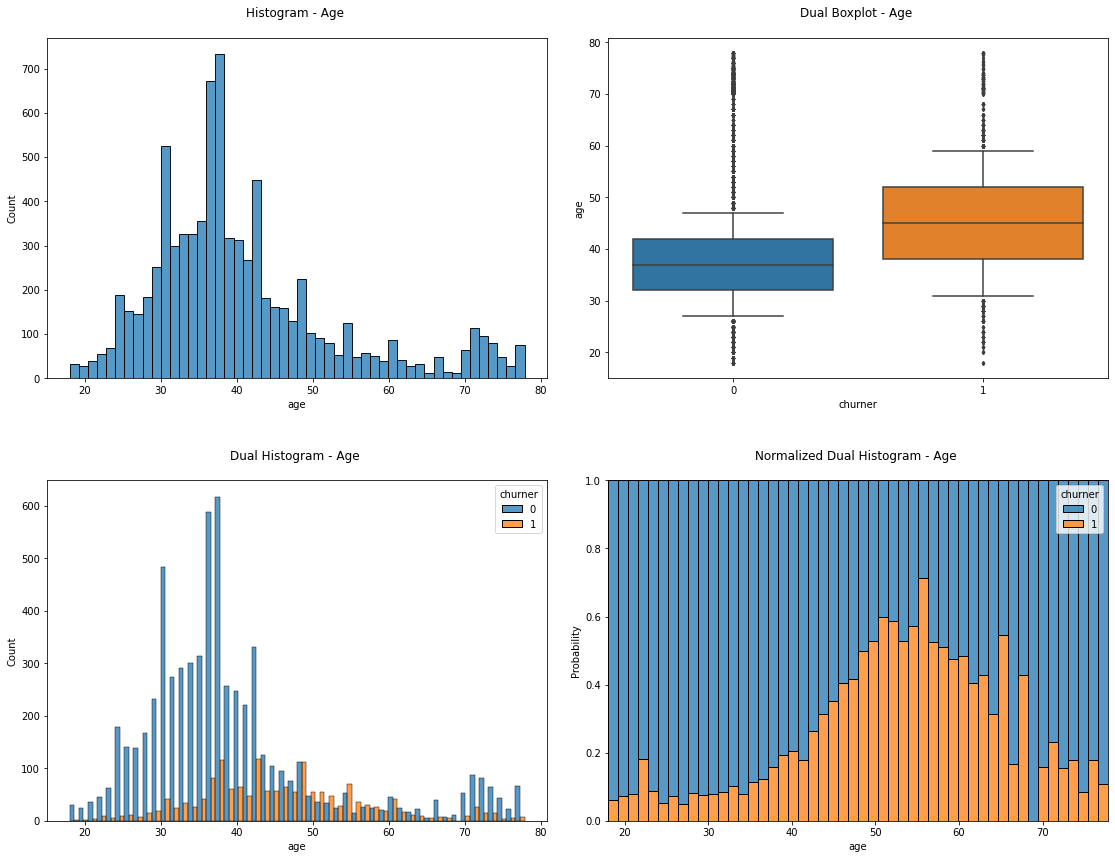

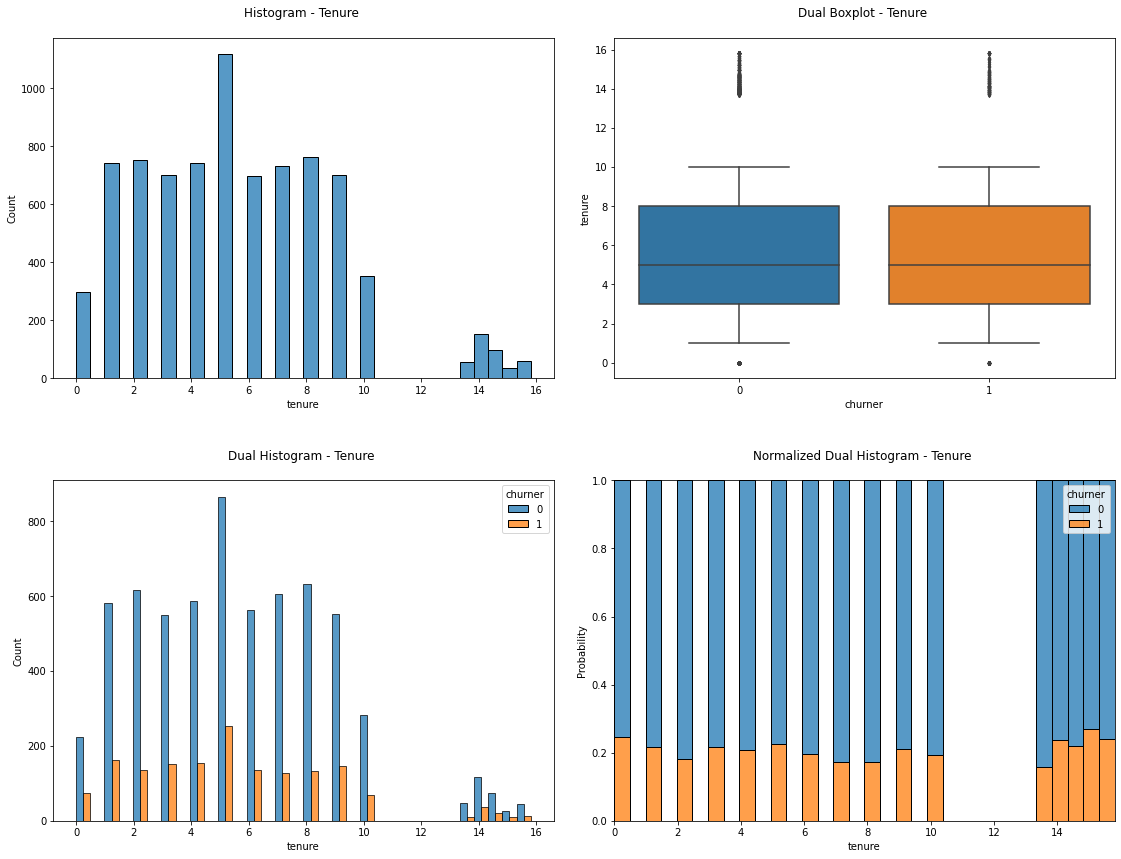

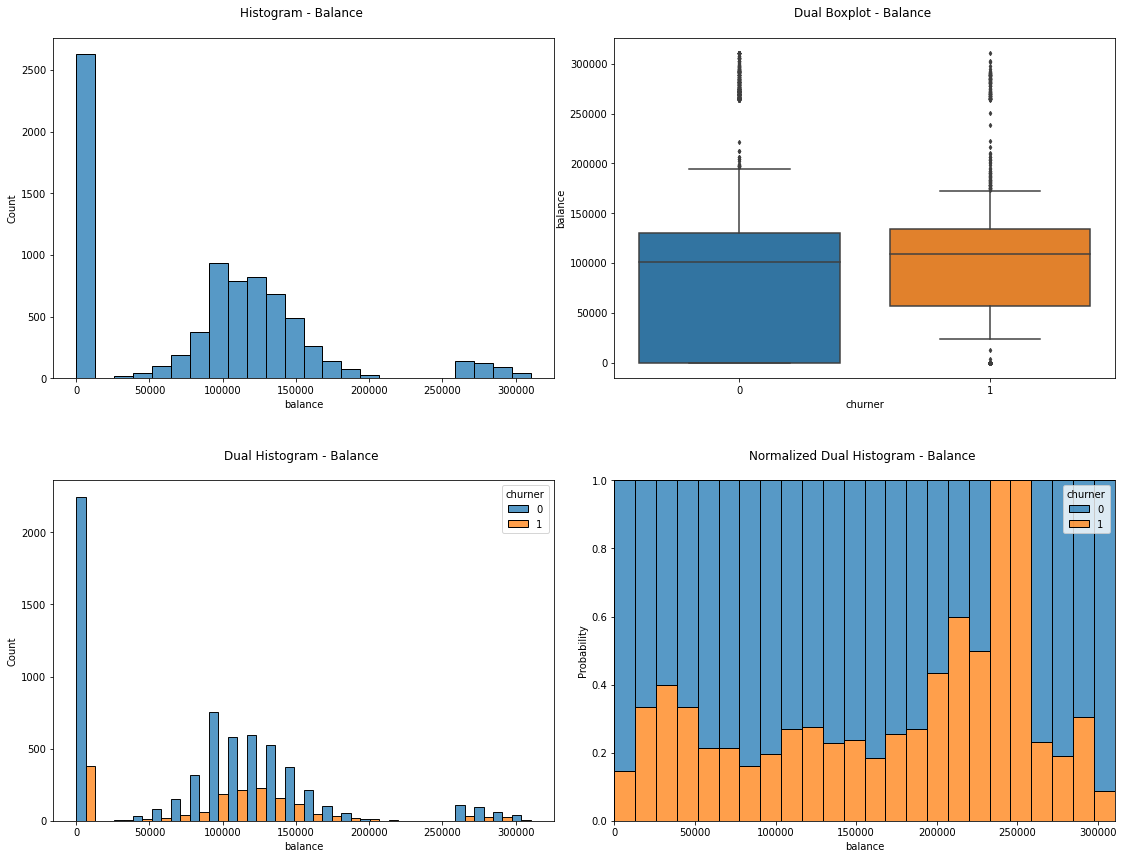

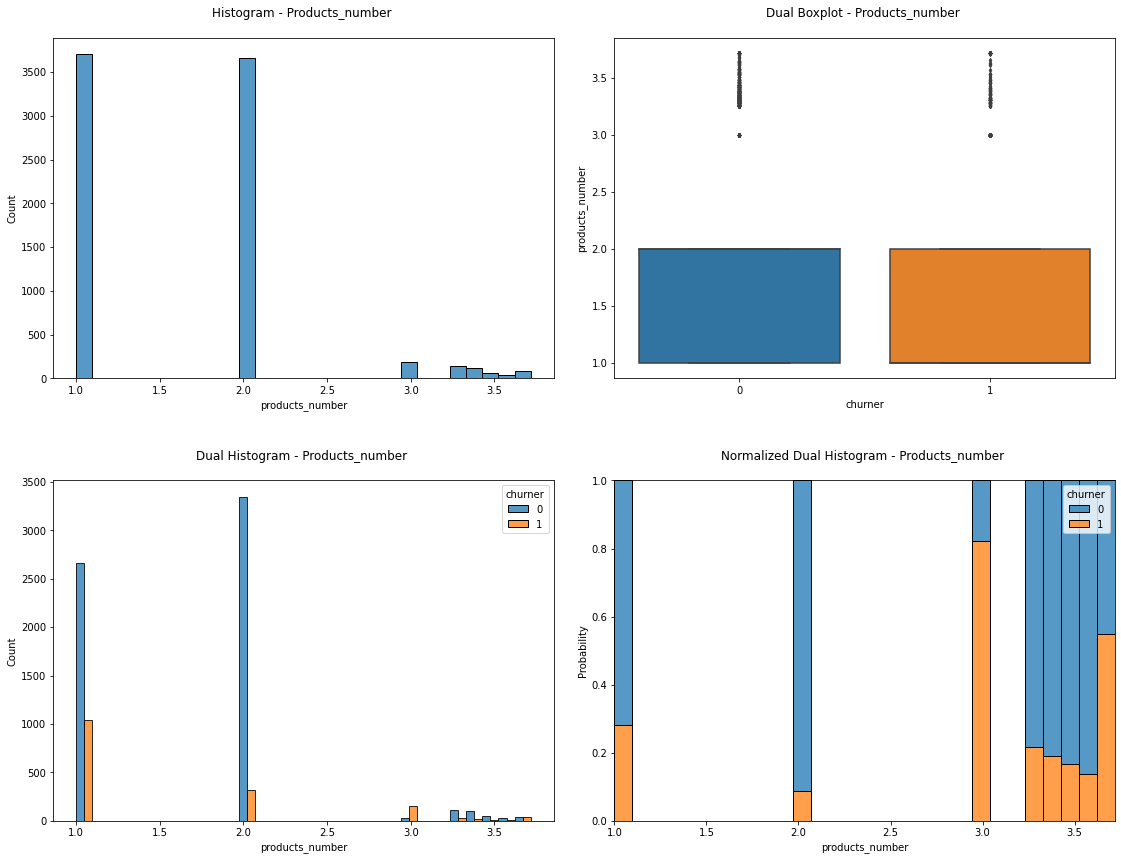

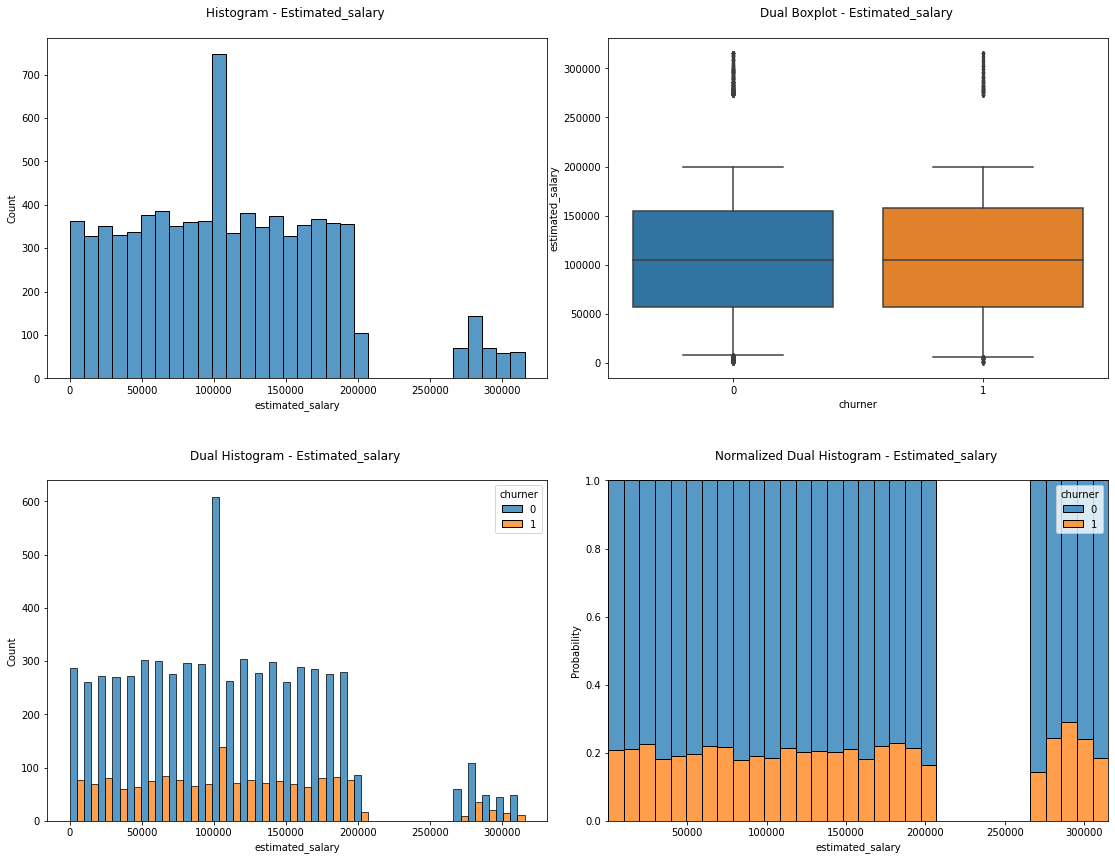

In [44]:
# plot box-plots and histograms

for feat in numeric_columns:

    width=16
    height=np.round(width*.75,0)
    fig, ax = plt.subplots(2, 2, figsize=(width, height))
    ax = ax.flatten()
    # adjust layout
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.3)

    sns.histplot(
    data = data,
    x = feat,
    stat='count',
    ax = ax[0]
    )
    ax[0].set_title('Histogram - {} \n'.format(feat.capitalize()))

    sns.boxplot(
        data = data,
        y = feat,
        x = 'churner',
        fliersize=3,
        whis=.5,
        ax=ax[1]
    )
    ax[1].set_title('Dual Boxplot - {} \n'.format(feat.capitalize()))

    sns.histplot(
        data = data,
        x = feat,
        hue = 'churner',
        stat='count',
        multiple='dodge',
        ax = ax[2]
    )
    ax[2].set_title('Dual Histogram - {} \n'.format(feat.capitalize()))

    sns.histplot(
        data = data,
        x = feat,
        hue = 'churner',
        stat='probability',
        multiple='fill',
        ax = ax[3]
    )
    ax[3].set_title('Normalized Dual Histogram - {} \n'.format(feat.capitalize()))

    # save figure
    fig.savefig(
        fname='../images/'+feat+'_dist.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight')

    #plt.show()

## Visualize Categorical Features

In [45]:
# create categorical data frame
data = pd.concat([X_train[categorical_columns], pd.DataFrame(y_train, index=X_train.index, columns=['churner'])], axis=1)
data.head()

,country,gender,credit_card,active_member,churner
customer_id,,,,,
15759244,Germany,Male,yes,yes,0
15725997,France,Female,yes,yes,0
15724296,France,Male,no,no,0
15636820,Germany,Male,yes,no,0
15744529,France,Male,yes,yes,0


In [46]:
# show most frequent categories for converters vs non-converters
data.groupby('churner').agg(pd.Series.mode)

,country,gender,credit_card,active_member
churner,,,,
0,France,Male,yes,yes
1,France,Female,yes,no


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


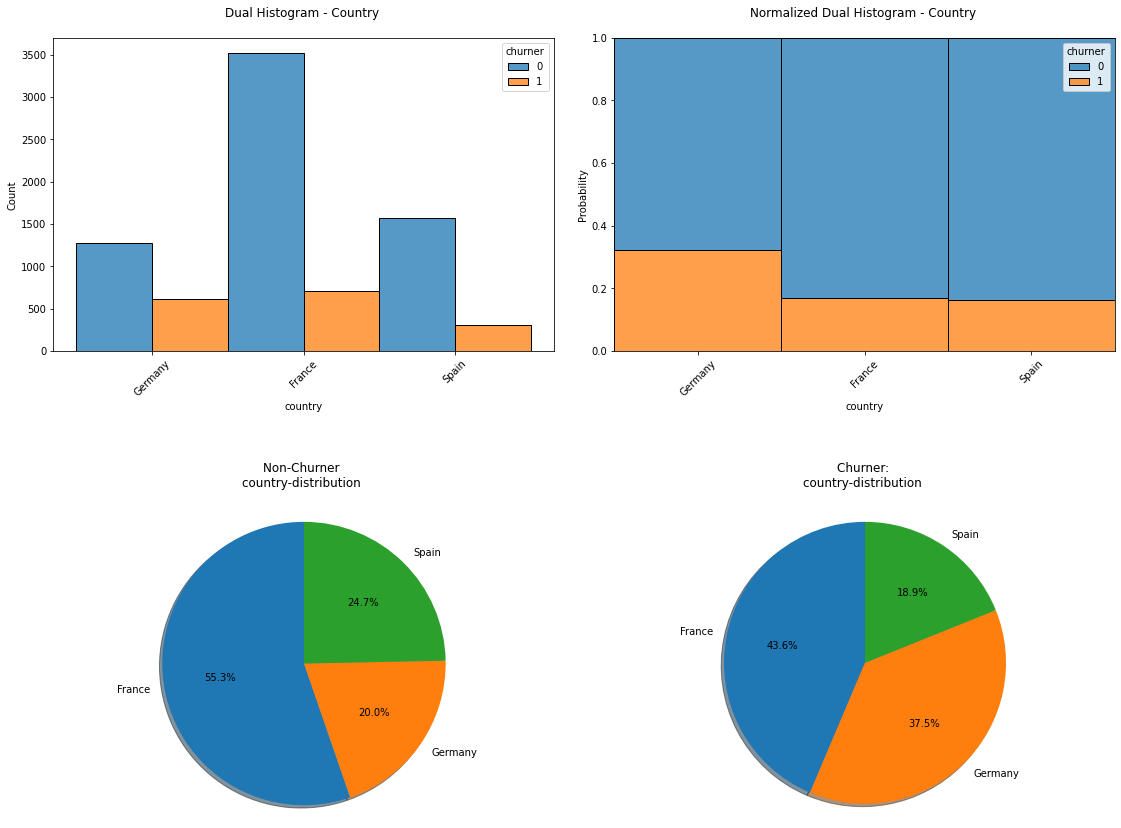

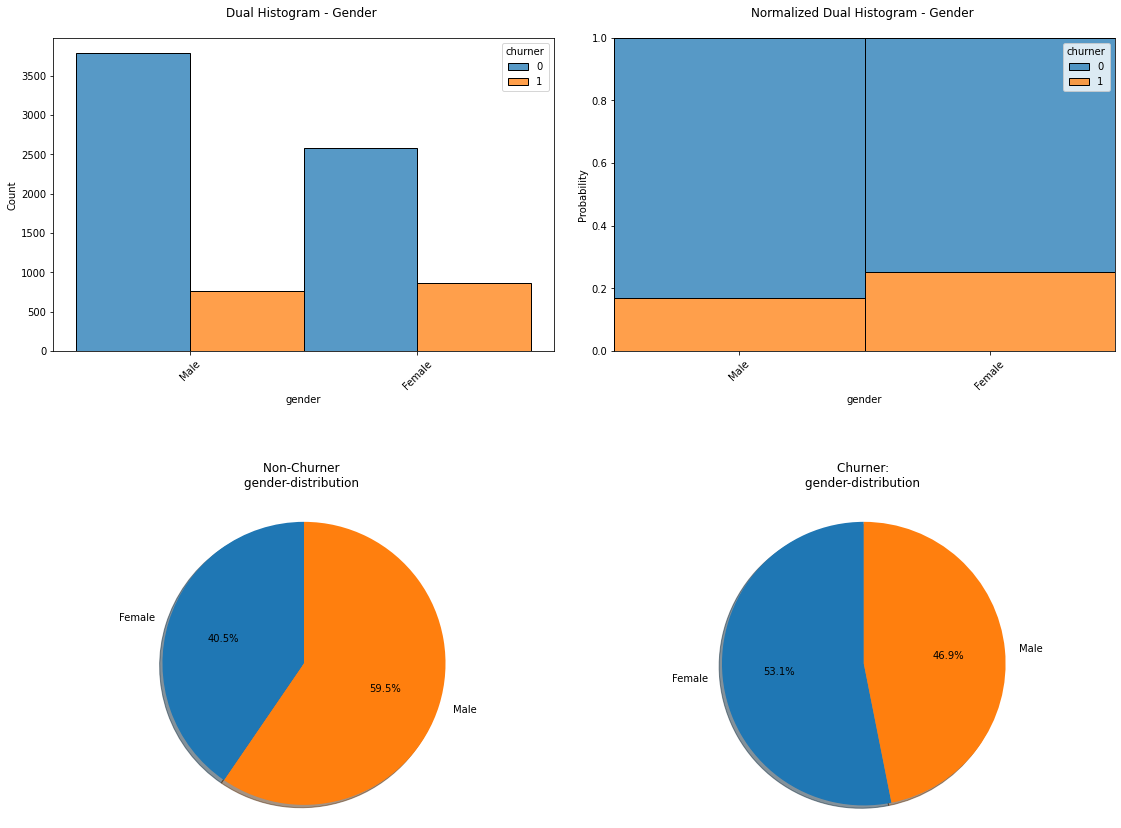

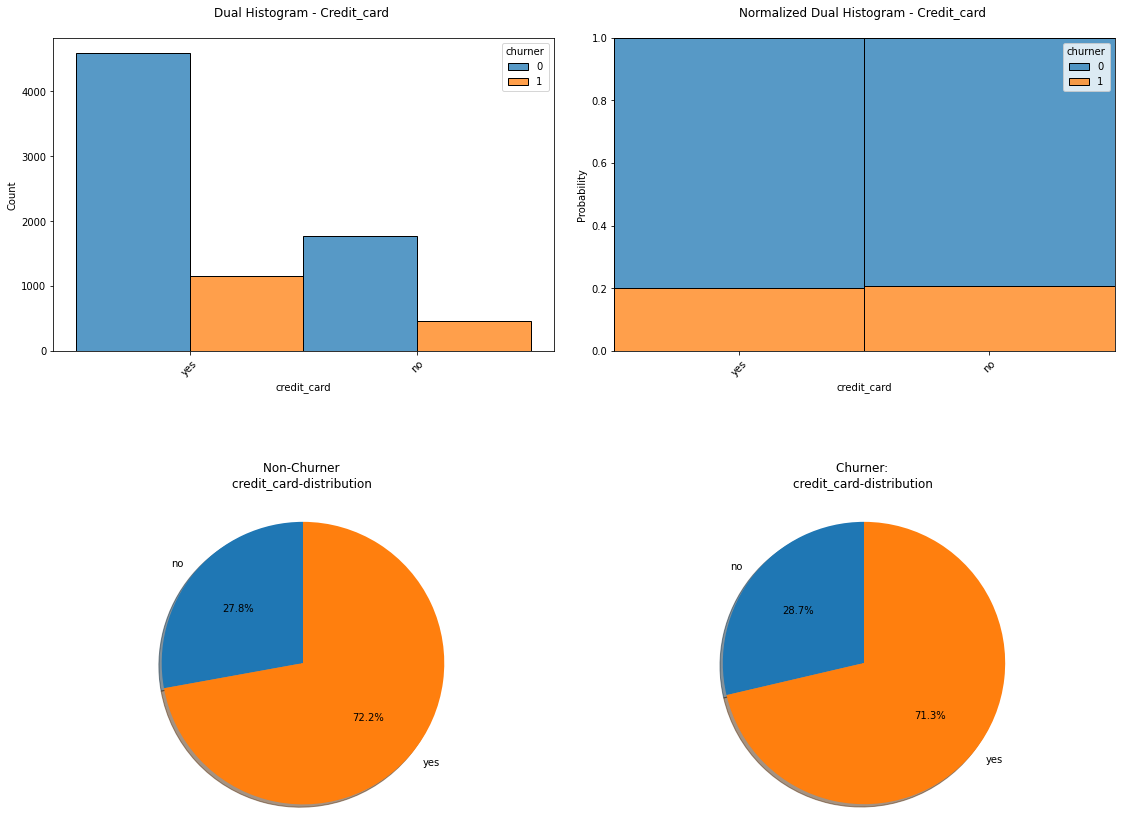

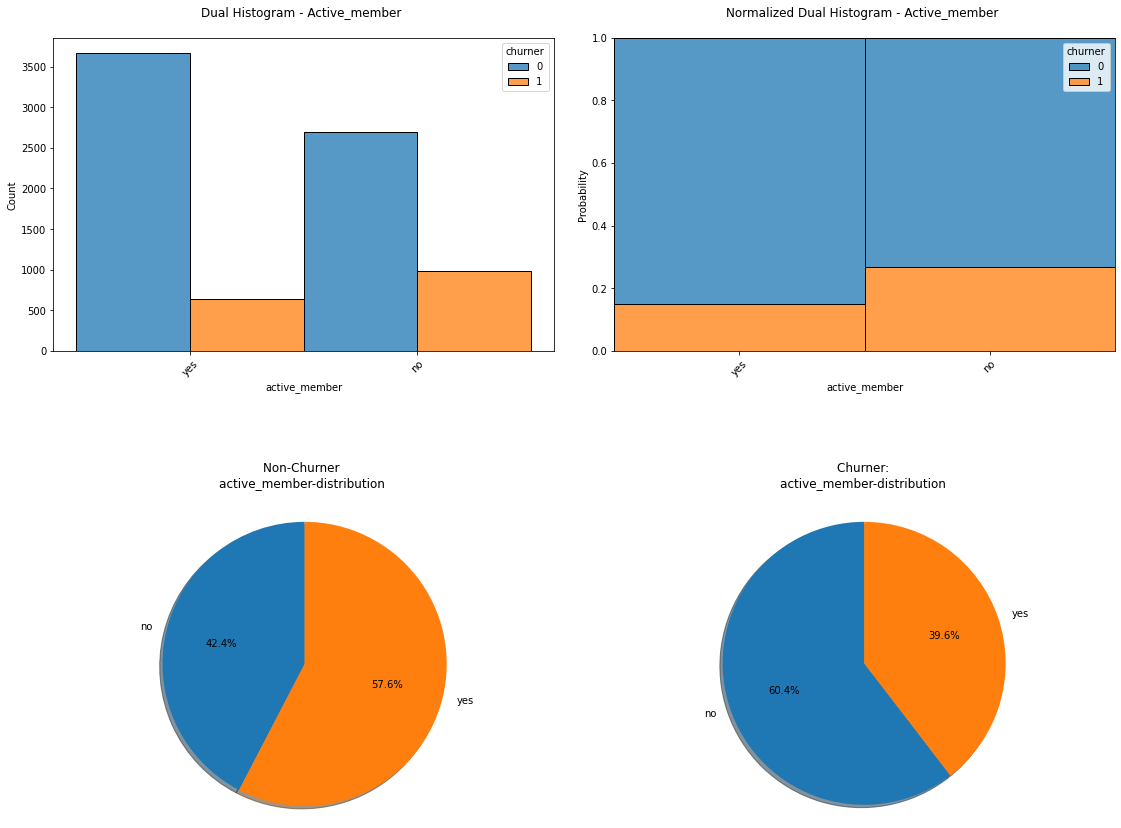

In [47]:
# plot histograms

for feat in categorical_columns:

    width=16
    height=np.round(width*.75,0)
    fig, ax = plt.subplots(2, 2, figsize=(width, height))
    ax = ax.flatten()
    # adjust layout
    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(hspace=0.5)

    sns.histplot(
        data = data,
        x = feat,
        hue = 'churner',
        stat='count',
        multiple='dodge',
        ax = ax[0]
    )
    ax[0].set_xticklabels(data[feat].unique(), rotation=45)
    ax[0].set_title('Dual Histogram - {} \n'.format(feat.capitalize()))

    sns.histplot(
        data = data,
        x = feat,
        hue = 'churner',
        stat='probability',
        multiple='fill',
        ax = ax[1]
    )
    ax[1].set_xticklabels(data[feat].unique(), rotation=45)
    ax[1].set_title('Normalized Dual Histogram - {} \n'.format(feat.capitalize()))

    # pie-plot for the non-converter
    tmp =  data[data['churner']==0].groupby(by=[feat]).count().iloc[:,0] / data[data['churner']==0].shape[0]
    ax[2].pie(
            x=tmp.values.tolist(), 
            labels=tmp.index.to_list(), 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90
        )
    ax[2].set_title('Non-Churner \n'+feat+'-distribution \n')
    ax[2].axis('equal')

    # pie-plot for the converter
    tmp =  data[data['churner']==1].groupby(by=[feat]).count().iloc[:,0] / data[data['churner']==1].shape[0]
    ax[3].pie(
            x=tmp.values.tolist(), 
            labels=tmp.index.to_list(), 
            autopct='%1.1f%%', 
            shadow=True, 
            startangle=90
        )
    ax[3].set_title('Churner: \n'+feat+'-distribution \n')
    ax[3].axis('equal')

    # save figure
    fig.savefig(
        fname='../images/'+feat+'_dist.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight')

    #plt.show()

## One-Hote Encoding

In [48]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [49]:
# hotencode train data
X_train_hot_enc = enc.fit_transform(X_train[categorical_columns])
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15759244,687.0,44.000000,8.0,95368.0,2.0,1788.0,1.0,0.0,1.0,1.0,1.0
15725997,660.0,72.011478,5.0,100769.0,1.0,19200.0,0.0,0.0,0.0,1.0,1.0
15724296,684.0,41.000000,2.0,119783.0,2.0,120285.0,0.0,0.0,1.0,0.0,0.0
15636820,725.0,40.000000,8.0,104150.0,1.0,62028.0,1.0,0.0,1.0,1.0,0.0
15744529,510.0,63.000000,8.0,101215.0,2.0,115292.0,0.0,0.0,1.0,1.0,1.0


In [50]:
# hotencode test data
X_test_hot_enc = enc.transform(X_test[categorical_columns])
X_test_cat_hotenc = pd.DataFrame(X_test_hot_enc, columns=enc.get_feature_names_out()) 
X_test_cat_hotenc.index = X_test.index 
X_test_hotenc = pd.concat([X_test[numeric_columns], X_test_cat_hotenc], axis=1) 
X_test_hotenc.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,country_Germany,country_Spain,gender_Male,credit_card_yes,active_member_yes
customer_id,,,,,,,,,,,
15764618,815.0,72.0,6.0,0.0,1.000000,85168.0,0.0,1.0,0.0,1.0,1.0
15626385,714.0,33.0,10.0,103121.0,2.000000,49672.0,0.0,1.0,0.0,1.0,1.0
15687413,619.0,38.0,6.0,0.0,2.000000,117616.0,0.0,0.0,0.0,1.0,1.0
15759067,537.0,37.0,7.0,158412.0,3.717905,117691.0,1.0,0.0,0.0,1.0,1.0
15614049,664.0,55.0,8.0,0.0,2.000000,139162.0,0.0,0.0,1.0,1.0,1.0


In [51]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

# Training Simple Sklearn Decision Tree 

### Resampling Training Data to Account for Class Imbalance

In [52]:
# undersample training data to adress the class imbalance

# Create the under-sampler
sampler = RandomUnderSampler(random_state=123)

# Transform the training dataset
X_undersampled, y_undersampled = sampler.fit_resample(X_train_hotenc, y_train)
y_undersampled.shape

(3260,)

In [53]:
dt = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=3,
    min_samples_leaf=3, 
    random_state=123
)

In [54]:
# fit undersampled data
dt.fit(X_undersampled, y_undersampled)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                       random_state=123)

In [55]:
# evaluate accuracy on training set
dt.score(X_train_hotenc, y_train)

0.760125

In [56]:
# evaluate accuracy on test set
dt.score(X_test_hotenc, y_test)

0.7405

### Tuning Decision Tree

In [57]:
# parameters for Decision Tree
parameters = {
    'max_depth': (3, 4, 5, None),
    'min_samples_split': (1, 2, 3, 4, 5, 6),
    'min_samples_leaf': (1, 2, 3, 4, 5, 6)
    }

#### Tune Model on Undersampled Data (Oversampling did non work out well! so no need trying it again!)

In [58]:
model_dt = GridSearchCV(
    dt, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

# fit model on undersampled data
model_dt.fit(X_undersampled, y_undersampled)

# evaluate accuracy on training set
print('recall score in train data: {:.2f}'.format(model_dt.score(X_train_hotenc, y_train))) 

# evaluate accuracy on test set
print('recall score in test data: {:.2f}'.format(model_dt.score(X_test_hotenc, y_test)))

recall score in train data: 0.77
recall score in test data: 0.79



72 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\tree\_classes.py", line 969, in fit
    super().fit(
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\tree\_classes.py", line 265, in fit
    check_scalar(
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\utils\validation.py", line 1480, in check_

In [59]:
# show best model parameters
model_dt.best_params_

{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}

# Training Sklearn Random Forest

In [60]:
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=3,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [61]:
rf.fit(X_train_hotenc, y_train)

RandomForestClassifier(max_depth=3, max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [62]:
# evaluate accuracy on training set
rf.score(X_train_hotenc, y_train)

0.797

In [63]:
# evaluate accuracy on test set
rf.score(X_test_hotenc, y_test)

0.7965

### Tuning Random Forest

In [64]:
# parameters for Random Forest
parameters = {
    'n_estimators': (50, 100, 200, 400),
    'max_depth': (3, 5, None),
    'class_weight' : (None, "balanced")
    }

model_rf = GridSearchCV(
    rf, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

In [65]:
model_rf.fit(X_train_hotenc, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=3, max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-3,
             param_grid={'class_weight': (None, 'balanced'),
                         'max_depth': (3, 5, None),
                         'n_estimators': (50, 100, 200, 400)},
             scoring=make_scorer(recall_score))

In [66]:
# evaluate recall score on training set
model_rf.score(X_train_hotenc, y_train)

0.7042944785276074

In [67]:
# evaluate recall score on test set
model_rf.score(X_test_hotenc, y_test)

0.7125307125307125

In [68]:
model_rf.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, n_estimators=200, random_state=123)

# Training Sklearn Gradient Boosting

In [69]:
# get class imbalance correction factor for minority class i.e. converters
class_correction_factor = get_class_imbalance_correction_factor(df, 'churn')
class_correction_factor # multiply the minority class with this factor

3.909180166912126

In [70]:
# init model class
gb = GradientBoostingClassifier(
    n_estimators=100, 
    max_depth=3,
    max_features='log2', 
    random_state=123)

# fit model without class weighting
gb.fit(X_train_hotenc, y_train)

# evaluate accuracy on training set
print('accuracy score without class weighting in train data: {:.2f}'.format(gb.score(X_train_hotenc, y_train))) 

# evaluate accuracy on test set
print('accuracy score without class weighting in test data: {:.2f}'.format(gb.score(X_test_hotenc, y_test)))


# fit model with class weighting

# define the sample weights
sample_weights = [class_correction_factor if y==1 else 1 for y in y_train]

# fit the classifier to your training data
gb.fit(X_train_hotenc, y_train, sample_weight=sample_weights)

# evaluate accuracy on training set
print('accuracy score with class weighting in train data: {:.2f}'.format(gb.score(X_train_hotenc, y_train))) 

# evaluate accuracy on test set
print('accuracy score with class weighting in test data: {:.2f}'.format(gb.score(X_test_hotenc, y_test)))


accuracy score without class weighting in train data: 0.86
accuracy score without class weighting in test data: 0.84
accuracy score with class weighting in train data: 0.80
accuracy score with class weighting in test data: 0.77


### Tuning Gradient Boosting

In [71]:
# hyper-parameters for Gradient Boosting
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, 7, None)
}


#### Tune Model Without Sample Weighting

In [72]:
# set up the model
model_gb = GridSearchCV(
    gb, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

# fit the model with equal class weights and with class weights adapted to class imbalance
model_gb.fit(X_train_hotenc, y_train)

# evaluate accuracy on training set
print('recall score without class weighting in train data: {:.2f}'.format(model_gb.score(X_train_hotenc, y_train)))

# evaluate accuracy on test set
print('recall score without class weighting in test data: {:.2f}'.format(model_gb.score(X_test_hotenc, y_test)))

# get best parameters
print('model best parameters: ', model_gb.best_params_)

recall score without class weighting in train data: 0.47
recall score without class weighting in test data: 0.50
model best parameters:  {'max_depth': 3, 'n_estimators': 200}


#### Tune Model With Sample Weighting

In [73]:
# set up the model
model_gb = GridSearchCV(
    gb, 
    parameters,
    scoring=make_scorer(recall_score),
    cv=3, 
    n_jobs =-3)

# fit the model with equal class weights and with class weights adapted to class imbalance
model_gb.fit(X_train_hotenc, y_train, sample_weight=sample_weights)

# evaluate accuracy on training set
print('recall score without class weighting in train data: {:.2f}'.format(model_gb.score(X_train_hotenc, y_train)))

# evaluate accuracy on test set
print('recall score without class weighting in test data: {:.2f}'.format(model_gb.score(X_test_hotenc, y_test)))

# get best parameters
print('model best parameters: ', model_gb.best_params_)

recall score without class weighting in train data: 0.74
recall score without class weighting in test data: 0.73
model best parameters:  {'max_depth': 3, 'n_estimators': 50}


# Model Evaluation

## Single Decision Tree Evaluation
### Area Under Curve and Area Under Recall-Precision Curve

AUC Decision Tree:  0.7874546349122621
AUPRC Decision Tree:  0.4651399571869222


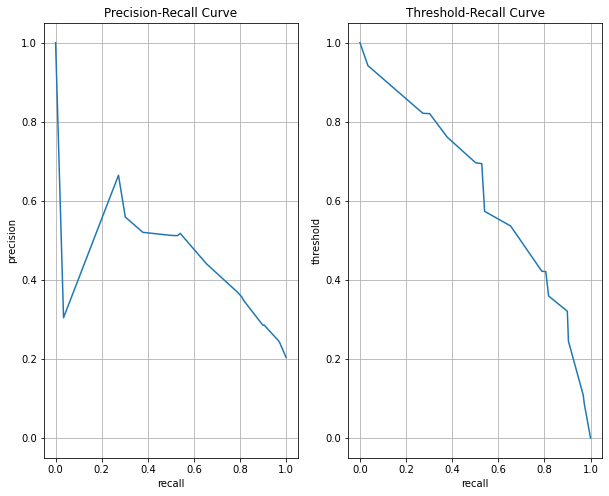

In [74]:
# calculate AUC for decision tree
auc = roc_auc_score(y_test, model_dt.predict_proba(X_test_hotenc)[:,1])
print('AUC Decision Tree: ', auc)

# calculate AUPRC for decision tree
auprc = average_precision_score(y_test, model_dt.predict_proba(X_test_hotenc)[:,1])
print('AUPRC Decision Tree: ', auprc)

# plot recall vs precision for decision tree model
fig = plot_threshold_recall_precision_curves(model_dt, X_test_hotenc, y_test)

# save figure
fig.savefig(
        fname='../images/recall_precision_tree.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

### Cummulative Gains Curve and Lift Curve

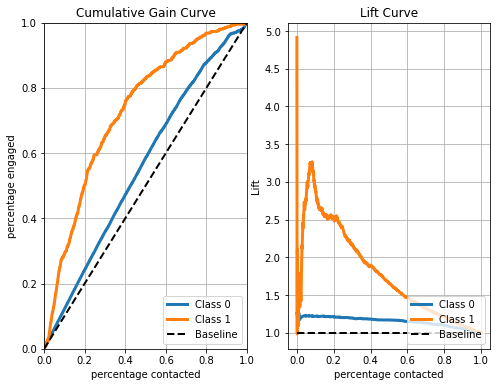

In [75]:
# plot cummulative gains and lift curves
fig = plot_cap_lift_curves(model_dt, X_test_hotenc, y_test)

# save figure
fig.savefig(
    fname='../images/cap_lift_curves_tree.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

### Confusion Matrices

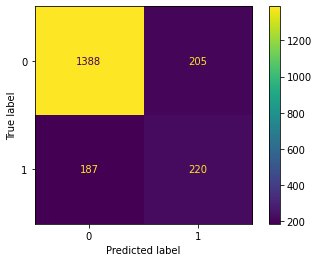

In [76]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 60%
# let´s relabel using that threshold of 60%

# plot confusion matrix for test data
disp = plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model_dt,
    threshold=0.6)

# save figure
disp.figure_.savefig(
    fname='../images/confusion_matrix_tree.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

### Visualize Tuned Decision Tree

In [77]:
dot_data = tree.export_graphviz(
    decision_tree=model_dt.best_estimator_,
    max_depth=3,
    feature_names=X_test_hotenc.columns.tolist(),
    class_names=['0', '1'],
    filled=True,
    rounded=True,
    special_characters=True,
    proportion=True
)

graph = graphviz.Source(dot_data)


# save image locally
graph.render(
    filename='../images/decision_tree_analysis',
    format='png',
    cleanup =True
)

# resize image
img = Image.open('../images/decision_tree_analysis.png')
width, height = img.size
scaling = 1.3
img_resized = img.resize((int(width * scaling), int(height * scaling)))
img_resized.save('../images/decision_tree_analysis.png')


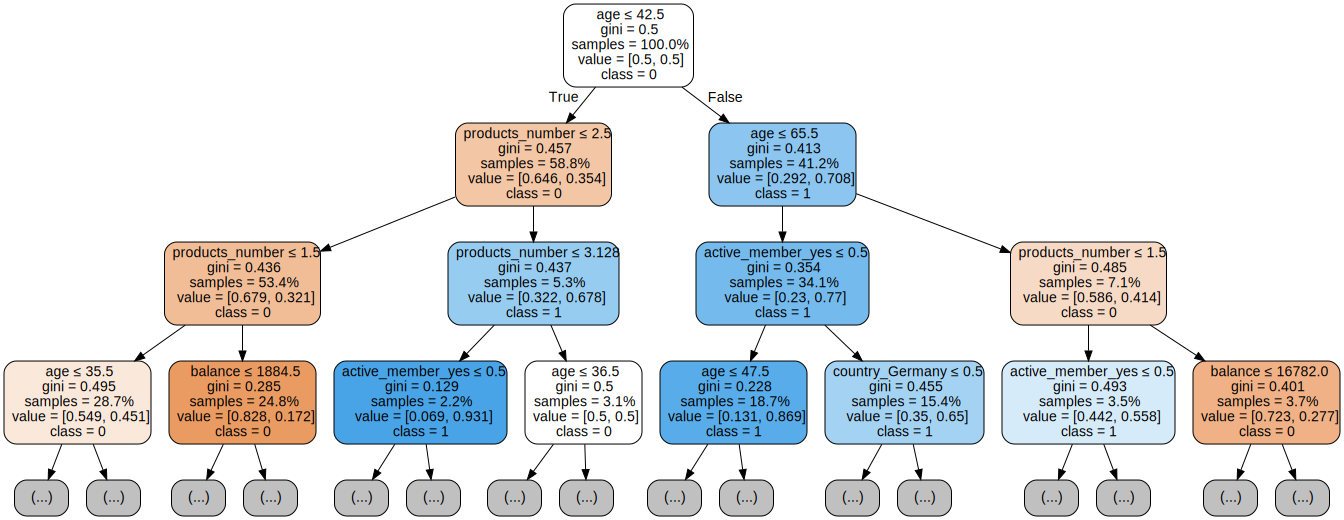

In [78]:
graph

## Random Forest Evaluation
### Area Under Curve and Area Under Recall-Precision Curve

AUC Random Forest:  0.810294115378861
AUPRC Random Forest:  0.5718940141410378


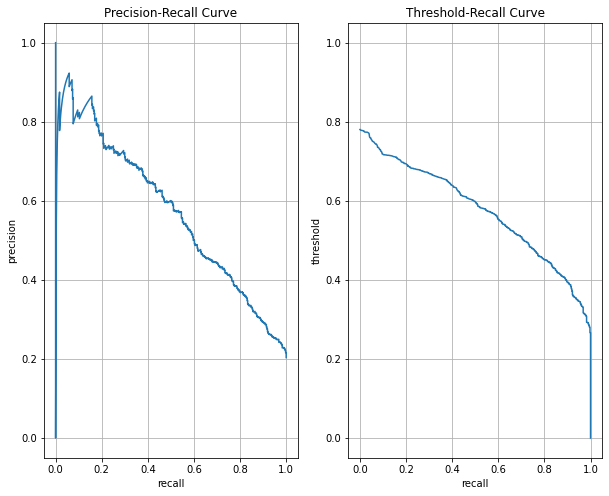

In [79]:
# calculate AUC for random forest
auc = roc_auc_score(y_test, model_rf.predict_proba(X_test_hotenc)[:,1])
print('AUC Random Forest: ', auc)

# calculate AUPRC for random forest
auprc = average_precision_score(y_test, model_rf.predict_proba(X_test_hotenc)[:,1])
print('AUPRC Random Forest: ', auprc)

# plot recall vs precision for random forest model
fig = plot_threshold_recall_precision_curves(model_rf, X_test_hotenc, y_test)

# save figure
fig.savefig(
        fname='../images/recall_precision_rf.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

### Cummulative Gains and Lift Curves

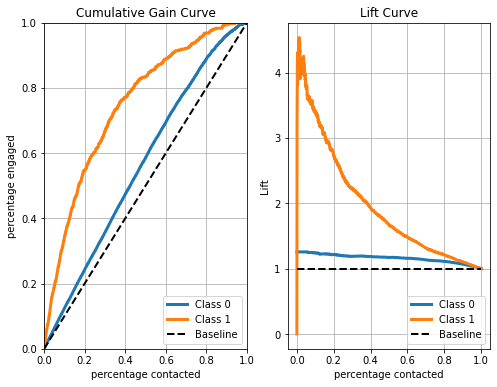

In [80]:
# plot cummulative gains and lift curves
fig = plot_cap_lift_curves(model_rf, X_test_hotenc, y_test)

# save figure
fig.savefig(
    fname='../images/cap_lift_curves_rf.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

### Confusion Matrices

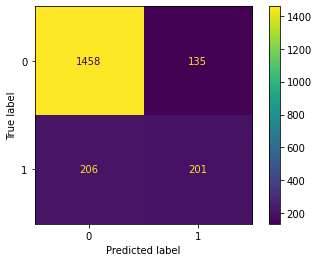

In [81]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 60%
# let´s relabel using that threshold of 60%

# plot confusion matrix for test data
disp = plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model_rf,
    threshold=0.6)

# save figure
disp.figure_.savefig(
    fname='../images/confusion_matrix_rf.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

## Gradient Boosted Trees Evaluation
### Area Under Curve and Area Under Recall-Precision Curve

AUC Gradient Boosting Classifier:  0.8357741408588866
AUPRC Gradient Boosting Classifier:  0.6272886246890067


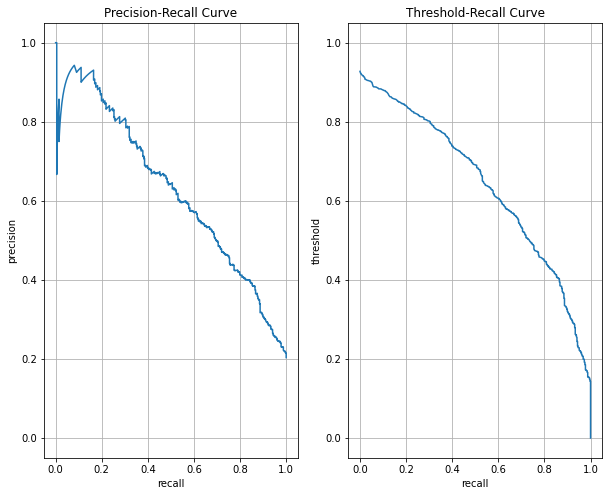

In [82]:
# calculate AUC for gradient boosting classifier
auc = roc_auc_score(y_test, model_gb.predict_proba(X_test_hotenc)[:,1])
print('AUC Gradient Boosting Classifier: ', auc)

# calculate AUPRC for random forest
auprc = average_precision_score(y_test, model_gb.predict_proba(X_test_hotenc)[:,1])
print('AUPRC Gradient Boosting Classifier: ', auprc)

# plot recall vs precision for gradient boosting model
fig = plot_threshold_recall_precision_curves(model_gb, X_test_hotenc, y_test)

# save figure
fig.savefig(
        fname='../images/recall_precision_gb.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
)

### Cummulative Gains and Lift Curves

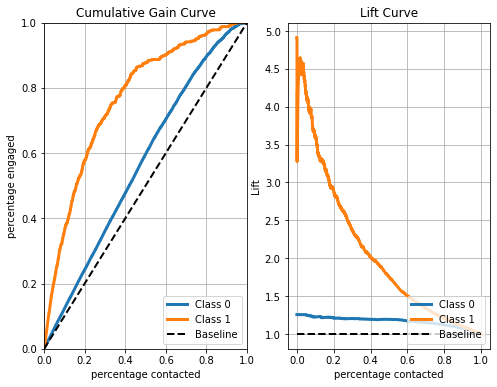

In [83]:
# plot cummulative gains and lift curves
fig = plot_cap_lift_curves(model_gb, X_test_hotenc, y_test)

# save figure
fig.savefig(
    fname='../images/cap_lift_curves_gb.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

### Confusion Matrices

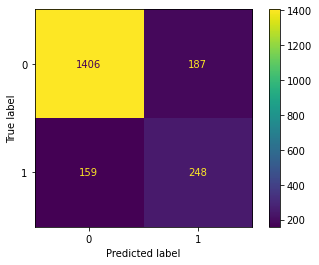

In [84]:
# lets say for whatever reason we want the recall to be around 40%, hence we accept a precision of around 40%; therefore we need to choose a threshold of around 60%
# let´s relabel using that threshold of 60%

# plot confusion matrix for test data
disp = plot_confusion_matrix(
    features=X_test_hotenc, 
    labels=y_test, 
    sklearn_model=model_gb,
    threshold=0.6)

# save figure
disp.figure_.savefig(
    fname='../images/confusion_matrix_gb.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

## Save Best Model

In [85]:
# Save the BEST classifier!!!
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model_gb, filename)

# Model Explainability Using Shap Values

In [86]:
X_test_hotenc.shape

(2000, 11)

In [87]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model_gb.best_estimator_,
    feature_perturbation = 'interventional',
    output = 'probability')

# get random sample
X = X_test_hotenc.sample(1000)

# calculate shap values
shap_values = explainer.shap_values(X)

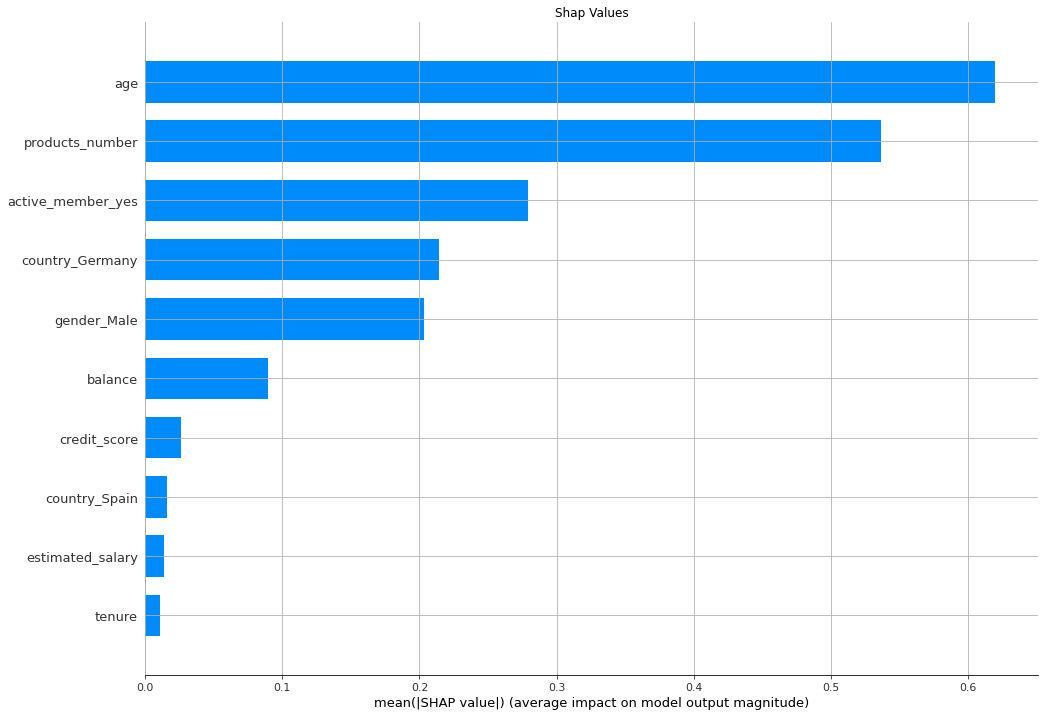

In [88]:
fig = plot_shap_values(shap_values, topn=10, plot_type='bar')

# save figure
fig.savefig(
    fname='../images/shap_values_bar.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

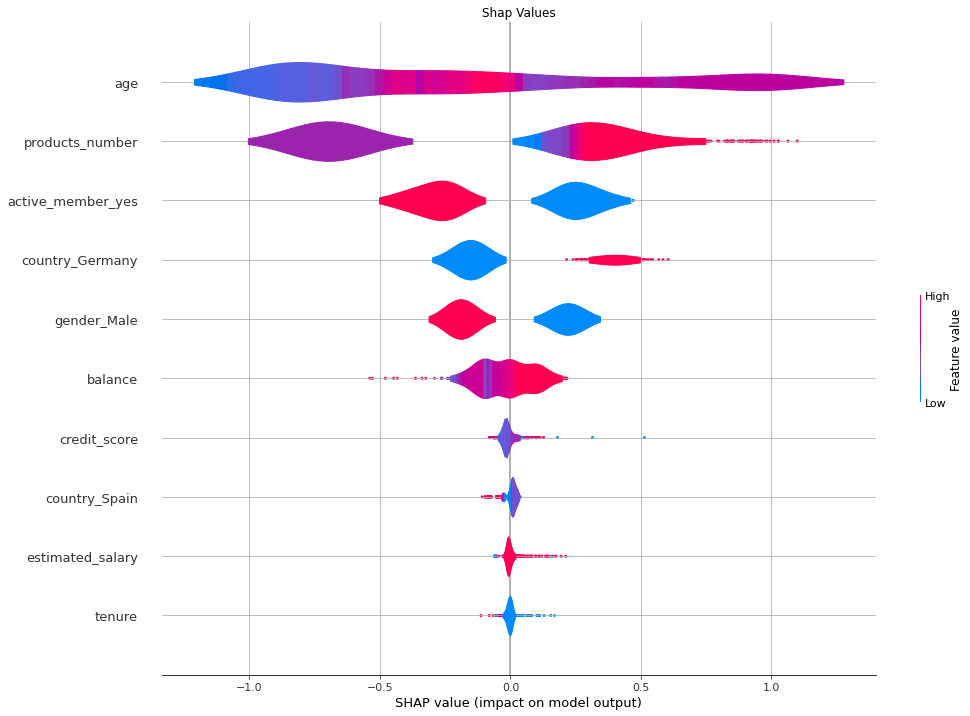

In [89]:
fig = plot_shap_values(shap_values, topn=10, plot_type='violin')

# save figure
fig.savefig(
    fname='../images/shap_values_violin.jpg',
    format='jpg',
    dpi=200, 
    bbox_inches='tight'
)

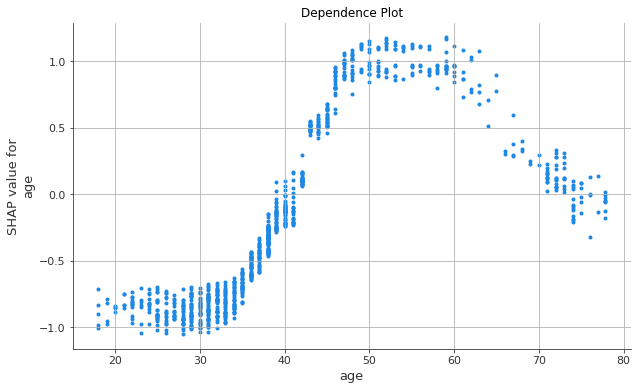

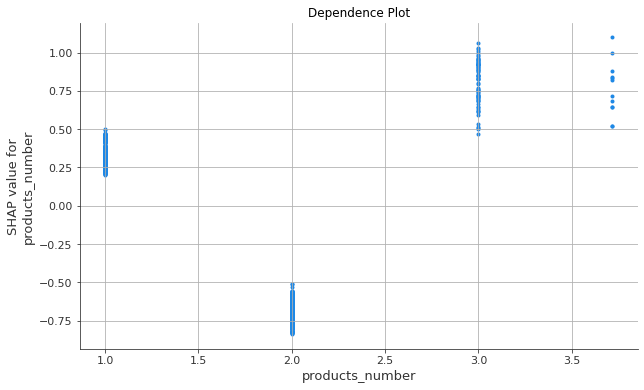

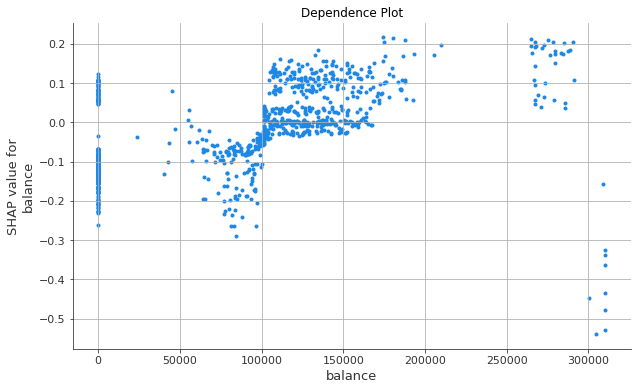

In [90]:
# plot dependence plots for the numerical features
for feat in ['age', 'products_number', 'balance']:
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.grid()
    ax.set_title('Dependence Plot')
    #ax.set_ylim(-1,1)
    shap.dependence_plot(
        ind = feat,
        shap_values = shap_values, 
        features = X,
        interaction_index=None,
        ax=ax
    )

    # save figure
    fig.savefig(
        fname='../images/shap_dependence_plot_'+feat+'.jpg',
        format='jpg',
        dpi=200, 
        bbox_inches='tight'
    )
    